In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance


In [2]:
def generate_periods(start_date, end_date, increment_days=10):
    """
    Generate periods of time between start_date and end_date
    Start date is always the same, end date is incremented by increment_days
    
    Parameters
    ----------
    start_date : str
        The start date of the period in the format 'YYYY-MM-DD'.
    end_date : str
        The end date of the period in the format 'YYYY-MM-DD'.
    increment_days : int, optional
        The number of days to increment the period.
    
    Returns
    -------
    list
        A list of tuples with the start and end dates of each period.
    """
    periods = []
    current_end_date = start_date + timedelta(days=365)
    while current_end_date <= end_date:
        periods.append((start_date.strftime('%Y-%m-%d'), current_end_date.strftime('%Y-%m-%d')))
        current_end_date += timedelta(days=increment_days)
    return periods

In [3]:
def eval_periods(df_list, features, n_clusters):
    """
    Evaluate the evolution of the clusters over time.
    
    Parameters
    ----------
    df_list : list
        A list of DataFrames with the data for each period.
    features : list
        A list of features to use for clustering.
    n_clusters : int
        The number of clusters to use.
    
    Returns
    -------
    ARI_scores : list
        A list of tuples with the period index and the Adjusted Rand Index.
    ks_p_values : dict
        A dictionary with the p-values of the Kolmogorov-Smirnov test for each feature.
    """
    scaler = StandardScaler()
    ari_scores = []
    ks_p_values = {feature: [] for feature in features}
    for i, df in enumerate(df_list):
        if i == 0:
            X_scaled = scaler.fit_transform(df[features])
            initial_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            initial_kmeans.fit(X_scaled)
            continue
        X_current = scaler.transform(df[features])
        kmeans_current = KMeans(n_clusters=n_clusters, random_state=42)
        current_clusters = kmeans_current.fit_predict(X_current)
        initial_clusters = initial_kmeans.predict(X_current)
        ari = adjusted_rand_score(initial_clusters, current_clusters)
        ari_scores.append((i, ari))
        current_features = df.groupby(current_clusters).mean()
        initial_features = df.groupby(initial_clusters).mean()
        for feature in features:
            _, p_value = ks_2samp(initial_features[feature], current_features[feature], mode='asymp')
            ks_p_values[feature].append(p_value)
    return ari_scores, ks_p_values   

In [11]:
def plot(ari_scores, ks_p_values):
    """
    Plot the ARI scores and the p-values of the Kolmogorov-Smirnov test.
    
    Parameters
    ----------
    ari_scores : list
        A list of tuples with the period index and the Adjusted Rand Index.
    ks_p_values : dict
        A dictionary with the p-values of the Kolmogorov-Smirnov test for each feature.
    
    Returns
    -------
        None
    """
    periods, ari_values = zip(*ari_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(periods, ari_values, marker='o', linestyle='-', color='b')
    plt.title("ARI Scores over Time Periods")
    plt.xlabel("Periods")
    plt.ylabel("ARI Score")
    plt.grid(True)
    plt.show()
    for feature, p_values in ks_p_values.items():
        plt.figure(figsize=(10, 6))
        plt.plot(periods, p_values, marker='o', linestyle='-', label=f'{feature} p-values')
        plt.title(f"KS Test P-Values for {feature} over Time Periods")
        plt.xlabel("Periods")
        plt.ylabel("P-Value")
        plt.axhline(0.95, color='r', linestyle='--', label='0,95 significance level')
        plt.legend()
        plt.grid(True)
        plt.show()

Connect to db and set up first transaction date and last transaction date

In [5]:
conn = sqlite3.connect('olist.db')
cursor = conn.cursor()
start_date = datetime(2016, 9, 4)
end_date = datetime(2018, 10, 17)
data_list = []

Create priodes to use in query

In [6]:
periods = generate_periods(start_date, end_date)

In [7]:
for period_start, period_end in periods:
    query = f"""
    WITH 
        review_scores AS (
        SELECT
            c.customer_unique_id,
            AVG(r.review_score) AS average_review_score
        FROM
            orders o
            JOIN order_reviews r ON o.order_id = r.order_id 
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        ),
        seller_count AS (
        SELECT
            c.customer_unique_id,
            COUNT(DISTINCT i.seller_id) AS nb_of_different_sellers
        FROM
            orders o
            JOIN order_items i ON o.order_id = i.order_id
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        ),
        rfm AS (
        SELECT
            c.customer_unique_id,
            MAX(o.order_purchase_timestamp) AS last_order_date,
            COUNT(o.order_id) AS frequency,
            SUM(i.price) AS monetary
        FROM
            orders o
            JOIN order_items i ON o.order_id = i.order_id
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        ),
        recency_calc AS (
        SELECT
            customer_unique_id,
            JULIANDAY('{period_end}') - JULIANDAY(last_order_date) AS recency
        FROM
            rfm
        ),
        payment_methods AS (
        SELECT
            c.customer_unique_id,
            SUM(CASE WHEN p.payment_type = 'credit_card' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS credit_card_rate,
            SUM(CASE WHEN p.payment_type = 'boleto' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS boleto_rate,
            SUM(CASE WHEN p.payment_type = 'voucher' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS voucher_rate,
            SUM(CASE WHEN p.payment_type = 'debit_card' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS debit_card_rate
        FROM
            orders o
            JOIN order_pymts p ON o.order_id = p.order_id
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            p.payment_type != 'not_defined'
            AND o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        )
    SELECT
        c.customer_unique_id,
        COALESCE(rs.average_review_score, 0) AS average_review_score,
        COALESCE(sc.nb_of_different_sellers, 0) AS nb_of_different_sellers,
        COALESCE(rc.recency, 0) AS recency,
        COALESCE(rfm.frequency, 0) AS frequency,
        COALESCE(rfm.monetary, 0) AS monetary,
        COALESCE(pm.credit_card_rate, 0) AS credit_card_rate,
        COALESCE(pm.boleto_rate, 0) AS boleto_rate,
        COALESCE(pm.voucher_rate, 0) AS voucher_rate,
        COALESCE(pm.debit_card_rate, 0) AS debit_card_rate
    FROM
        customers c
        LEFT JOIN review_scores rs ON c.customer_unique_id = rs.customer_unique_id
        LEFT JOIN seller_count sc ON c.customer_unique_id = sc.customer_unique_id
        LEFT JOIN recency_calc rc ON c.customer_unique_id = rc.customer_unique_id
        LEFT JOIN rfm ON c.customer_unique_id = rfm.customer_unique_id
        LEFT JOIN payment_methods pm ON c.customer_unique_id = pm.customer_unique_id;
    """
    data_list.append(pd.read_sql_query(query, conn))

conn.close()

Now all dataframes are in array covering differents periods

In [8]:
data_list[0].shape

(99441, 10)

Using the same query as past notebook, so I need to prepocess the data the same way and delete customers with no purchases

In [9]:
grouped_dfs = [
    df.groupby('customer_unique_id').agg({
        'average_review_score': 'mean',
        'nb_of_different_sellers': 'mean',
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean',
        'credit_card_rate': 'mean',
        'boleto_rate': 'mean',
        'voucher_rate': 'mean',
        'debit_card_rate': 'mean'
    }).loc[lambda x: x['monetary'] != 0]
    for df in data_list
]
print(grouped_dfs[0].shape)
print(grouped_dfs[-1].shape)


(22741, 9)
(95420, 9)


Print the first and last period to control the individuals are incresing  

## Simulation of periods
- we run an initial model and to it to compare with next period and test with the ARI, and if the nature of the data as change with Kolmogorov-Smirnov test, for a feature see if the value mean, group by different clusters change or not 

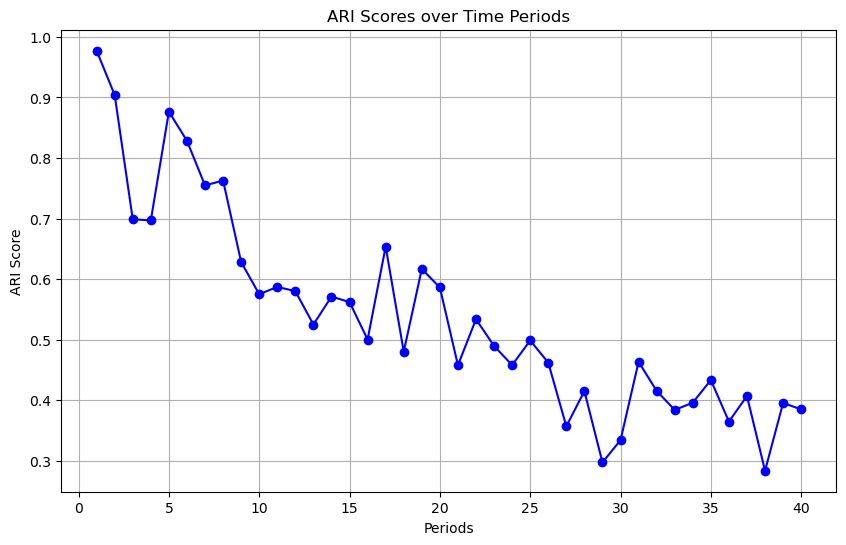

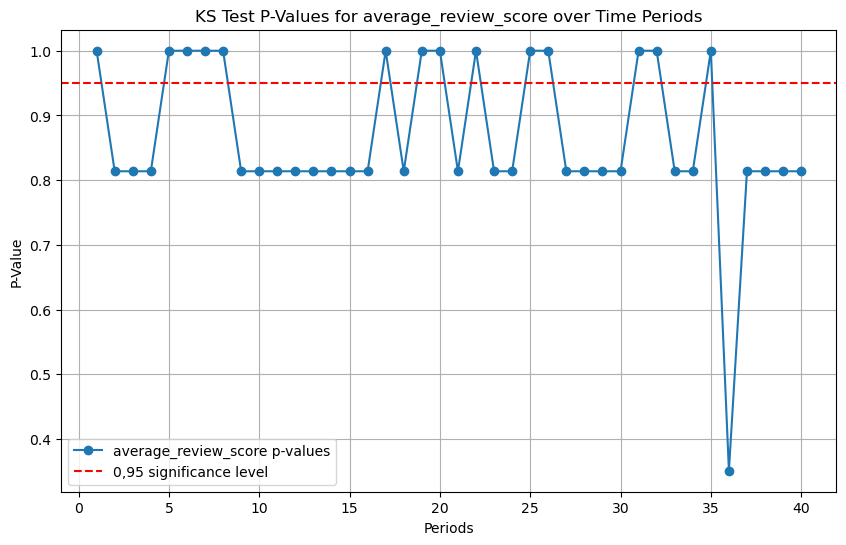

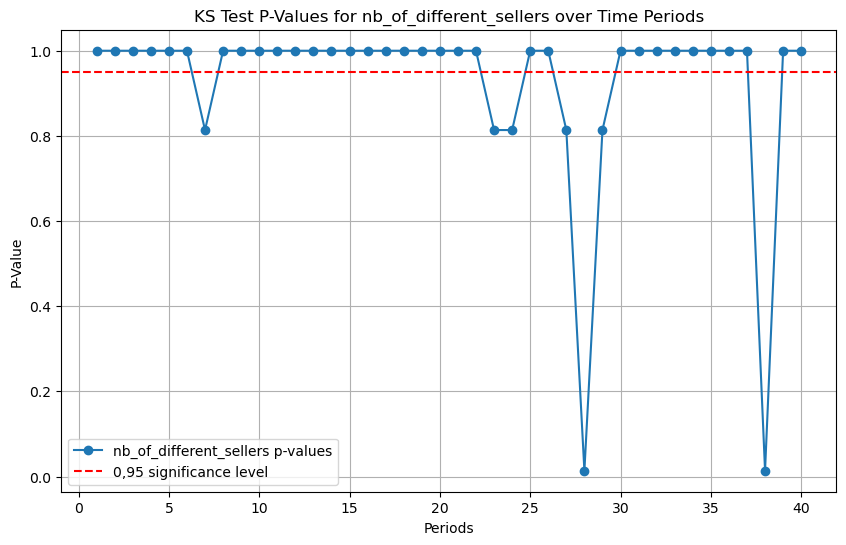

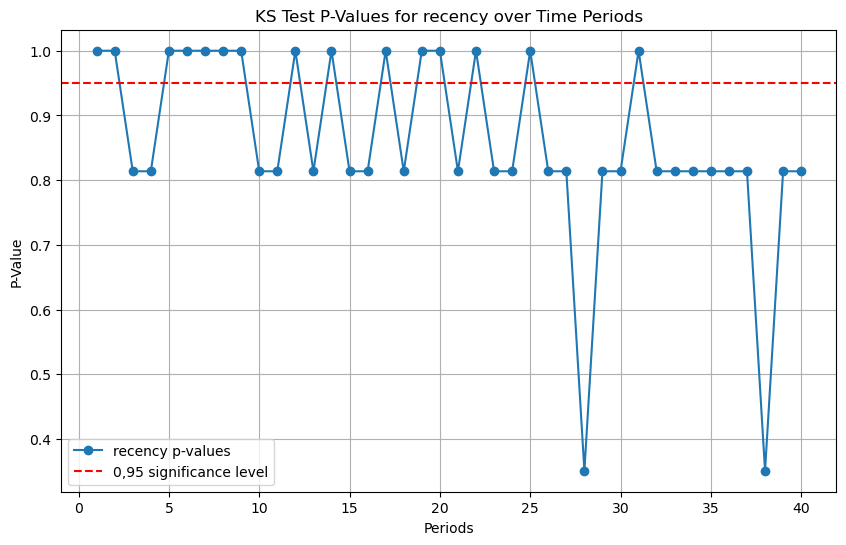

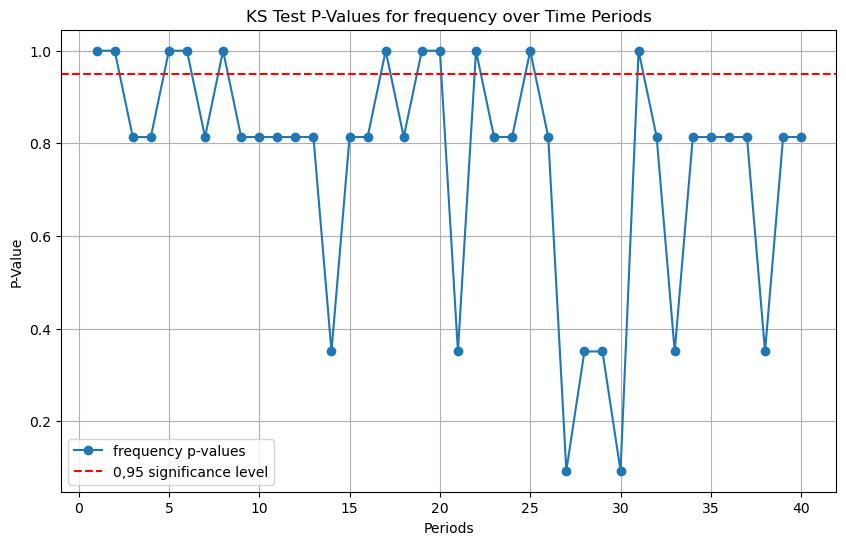

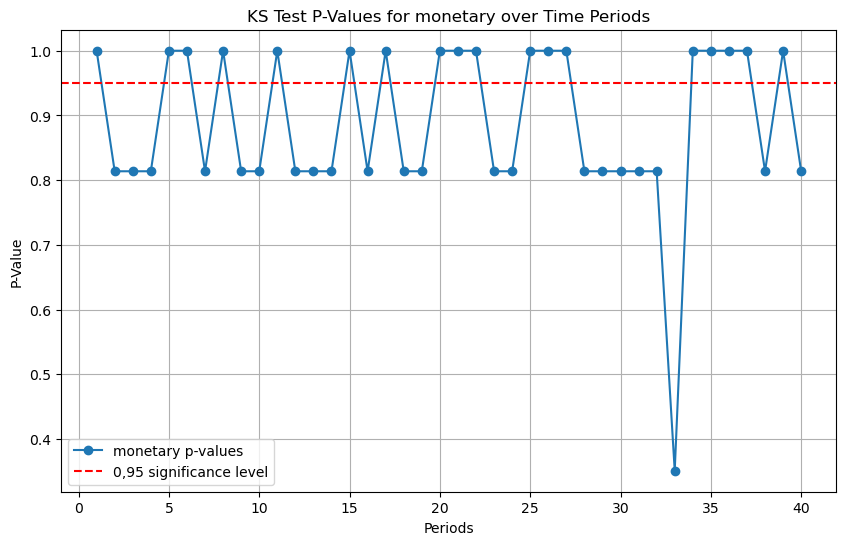

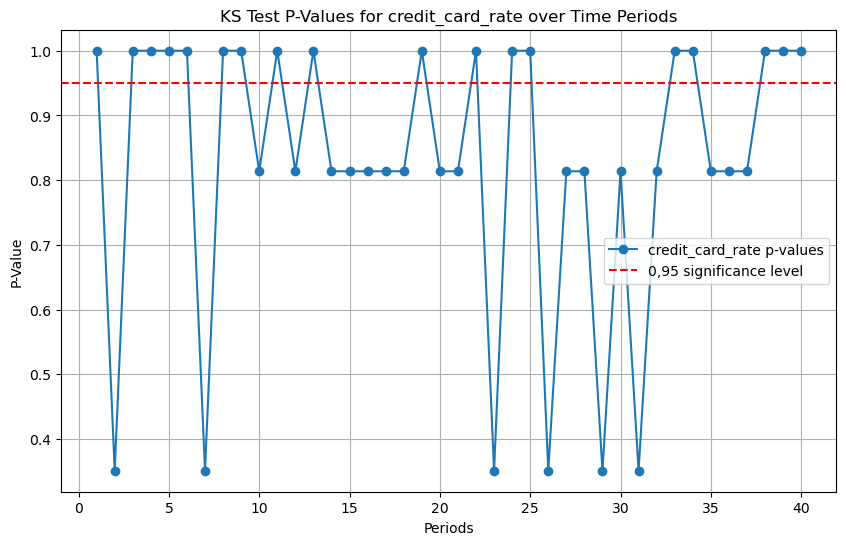

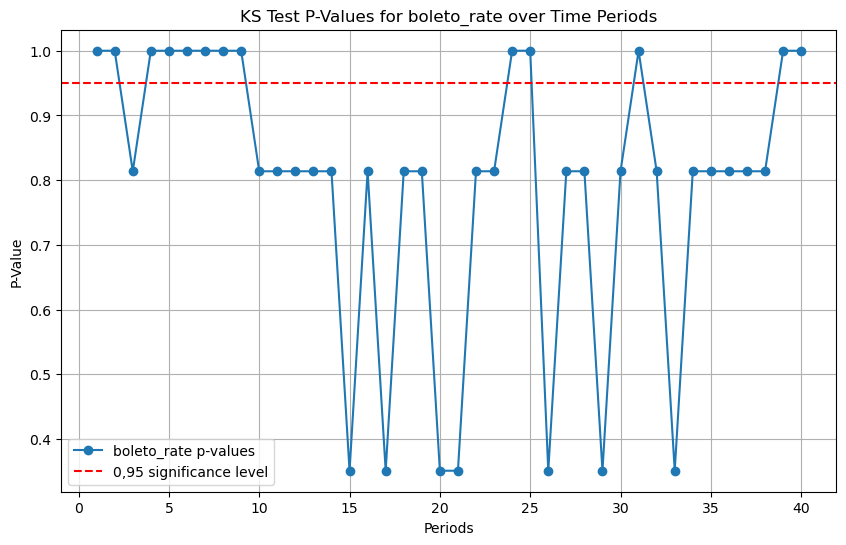

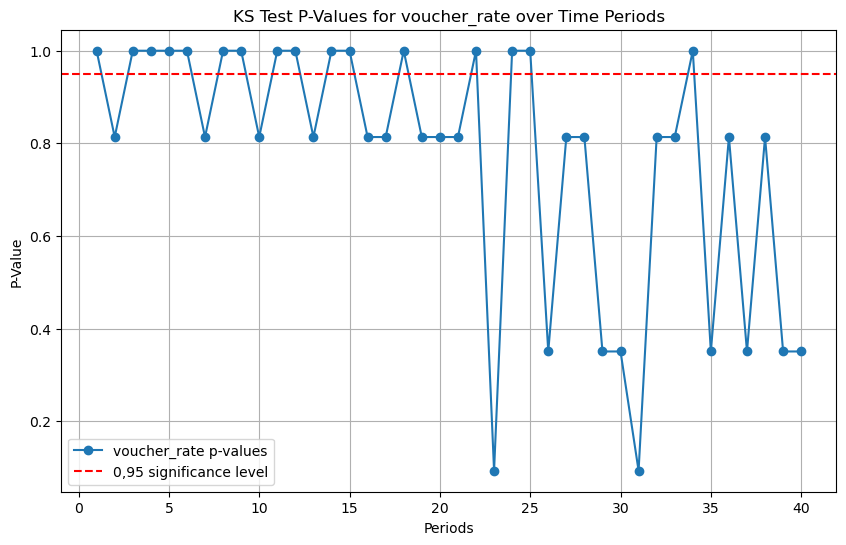

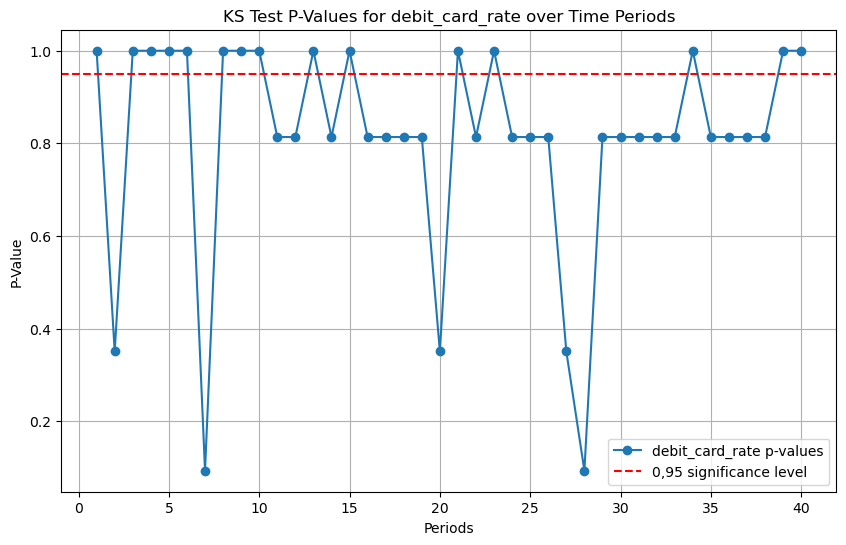

In [12]:
ari_scores, ks_p_values = eval_periods(grouped_dfs, ['average_review_score', 'nb_of_different_sellers', 'recency', 'frequency', 'monetary', 'credit_card_rate', 'boleto_rate', 'voucher_rate', 'debit_card_rate'], 7)
plot(ari_scores, ks_p_values)

- For most of the features the means values change in distribution in different clusters, but with adding more and more data from periods, it come back to approx same distribution in the time.

- In term of performance we can see after period 7, ARI go sinificativly down, it go down also during firsts periods but have a good period five, this can be explain by our KS test who show P values discrese and come back to 1, that means the data has not the same distributions during this period 


So we should update the model every 7 periods so 70 days